In [364]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import numpy as np
import PIL.Image
from functools import reduce


In [365]:
def predict(path, encoder, decoder, sizeWithoutChannel):
    img = PIL.Image.open(path)
    img = img.resize(sizeWithoutChannel)
    img = np.array(img)
    img = img / 255
    img = img.reshape(1, *sizeWithoutChannel, 1)
    outimg = reduce(lambda x, eachLayer: eachLayer(x), encoder, img)
    outimg = reduce(lambda x, eachLayer: eachLayer(x), decoder, outimg)

    outimg = np.array(outimg).reshape(*sizeWithoutChannel)
    return outimg

def path2inputimg(path, sizeWithoutChannel):
    img = PIL.Image.open(path)
    img = img.resize(sizeWithoutChannel)
    img = np.array(img)
    img = img / 255
    img = img.reshape(*sizeWithoutChannel, 1)
    return img

def showDatasetPerdiction(dataset, model):
  fig, ax = plt.subplots(ncols=np.array([*dataset]).shape[1],nrows=3)
  index = 0
  for origin, dest  in dataset:
    valiPredictions = model.encode(origin)
    valiPredictions = model.decode(valiPredictions)
    print(valiPredictions.shape)
    for i in range(len(valiPredictions)):
      ax[0][index].imshow(origin[i])
      ax[1][index].imshow(dest[i])
      ax[2][index].imshow(valiPredictions[i])
      index += 1
  plt.show()

In [366]:
IMGSIZE = (64, 64)
encoder = [
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu',  input_shape=IMGSIZE),
    keras.layers.MaxPooling2D(), # -> (32, 32, 64)

    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(), # -> (16, 16, 128)

    keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(), # -> (8, 8, 256)

    keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(), # -> (4, 4, 512)

    keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
]

class FontModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = encoder
        self.decoder = [
            keras.layers.UpSampling2D(),
            keras.layers.Conv2DTranspose(
                256, (3, 3), padding='same', activation='relu'), # -> (8, 8, 256)
            keras.layers.UpSampling2D(),
            keras.layers.Conv2DTranspose(
                128, (3, 3), padding='same', activation='relu'), # -> (16, 16, 128)
            keras.layers.UpSampling2D(),
            keras.layers.Conv2DTranspose(
                64, (3, 3), padding='same', activation='relu'), # -> (32, 32, 64)
            keras.layers.UpSampling2D(),
            keras.layers.Conv2DTranspose(
                1, (3, 3), padding='same', activation='sigmoid'), # -> (64, 64, 1)
        ]
        self.encoderAndDecoder = self.encoder + self.decoder
    def encode(self, x):
        return reduce(lambda x, eachLayer: eachLayer(x), self.encoder, x)
    def decode(self, x):
        return reduce(lambda x, eachLayer: eachLayer(x), self.decoder, x)
    def call(self, x):
        return reduce(lambda x, eachLayer: eachLayer(x), self.encoderAndDecoder, x)

# Create an instance of the model
model = FontModel()
trainLoss = tf.keras.metrics.Mean(name='train_loss')
valiLoss = tf.keras.metrics.Mean(name='vali_loss')

loss_object = tf.keras.losses.BinaryCrossentropy()#BinaryCrossentropy MeanSquaredError
optimizer = tf.keras.optimizers.Adam()
def getTrainStap(model):

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model.encode(images)
            predictions = model.decode(predictions)

            loss = loss_object(labels, predictions)
        # print(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        trainLoss(loss)
    return train_step


In [367]:
model.build(input_shape=(None, *IMGSIZE, 1))
model.summary()

Model: "font_model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_230 (Conv2D)         multiple                  640       
                                                                 
 max_pooling2d_116 (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_231 (Conv2D)         multiple                  73856     
                                                                 
 max_pooling2d_117 (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_232 (Conv2D)         multiple                  295168    
                                                                 
 max_pooling2d_118 (MaxPooli  multiple               

In [368]:

# img = processImg('./face1/1.jpg')
# layers = [
#     keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(2048, (3, 3), padding='same', activation='relu'),
#     keras.layers.Conv2D(2048, (3, 3), padding='same', activation='relu'),
#     keras.layers.UpSampling2D(),
#     keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
#     keras.layers.UpSampling2D(),    
#     keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
#     keras.layers.UpSampling2D(),
#     keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#     keras.layers.UpSampling2D(),
#     keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#     keras.layers.Conv2D(3, (3, 3), padding='same', activation='relu'),
# ]
# img = img.resize((128, 128))
# img = (np.array(img) / 255).reshape((1, 128, 128, 3))

# for layer in layers:
#     img = layer(img)
#     print(img.shape)

In [369]:
originRoot = 'fontInput'
destRoot = 'fontBinarized'
originFiles = os.listdir(originRoot)
destFiles = os.listdir(destRoot)
# 除去文件夹
originFiles = [f for f in originFiles if not os.path.isdir(os.path.join(originRoot,f))]
destFiles = [f for f in destFiles if not os.path.isdir(os.path.join(destRoot,f))]

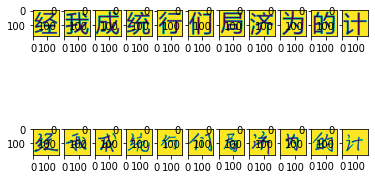

In [370]:
originRoot = 'fontInput'
destRoot = 'fontBinarized'
originFiles = os.listdir(originRoot)
destFiles = os.listdir(destRoot)
# 除去文件夹
originFiles = [f for f in originFiles if not os.path.isdir(os.path.join(originRoot,f))]
destFiles = [f for f in destFiles if not os.path.isdir(os.path.join(destRoot,f))]
if len(originFiles) != len(destFiles):
    raise Exception('originFiles and destFiles length not equal')
fig, ax = plt.subplots(ncols=len(originFiles),nrows=2)

for i in range(max(10,len(originFiles))):
    ax[0][i].imshow(PIL.Image.open(os.path.join(originRoot,originFiles[i])))
    ax[1][i].imshow(PIL.Image.open(os.path.join(destRoot,destFiles[i])))

In [371]:

BATCH_SIZE = 2

origin = tf.data.Dataset.from_tensor_slices([path2inputimg(os.path.join(originRoot,file),IMGSIZE) for file in originFiles]).batch(BATCH_SIZE)
dest = tf.data.Dataset.from_tensor_slices([path2inputimg(os.path.join(destRoot,file),IMGSIZE) for file in destFiles]).batch(BATCH_SIZE)

# origin 和 dest 一一对应
dataset = tf.data.Dataset.zip((origin,dest))

# 划分验证集和 train 集
valiDataset = dataset.take(int(len(originFiles) * 0.1))
trainDataset = dataset.skip(int(len(originFiles) * 0.1))

train
(2, 64, 64, 1) (2, 64, 64, 1)
(2, 64, 64, 1) (2, 64, 64, 1)
(2, 64, 64, 1) (2, 64, 64, 1)
(2, 64, 64, 1) (2, 64, 64, 1)
(1, 64, 64, 1) (1, 64, 64, 1)
vali
(2, 64, 64, 1) (2, 64, 64, 1)


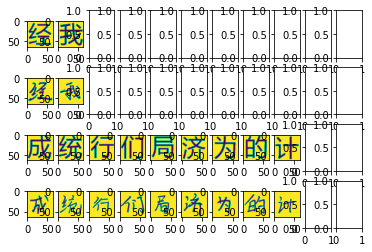

In [372]:
print('train')
for data in trainDataset:
  print(data[0].shape,data[1].shape)

print('vali')
for data in valiDataset:
  print(data[0].shape,data[1].shape)
  
fig, ax = plt.subplots(ncols=len(originFiles),nrows=4)

index = 0
for valiData in valiDataset:
  for i in range(len(valiData[0])):
    ax[0][index].imshow(valiData[0][i])
    ax[1][index].imshow(valiData[1][i])
    index += 1
index = 0
for trainData in trainDataset:
  for i in range(len(trainData[0])):
    ax[2][index].imshow(trainData[0][i])
    ax[3][index].imshow(trainData[1][i])
    index += 1


Epoch 1, Loss: 3.913357973098755, Validation Loss: 0.681969165802002, 
 1.0666666666666667 minutes left, 
Epoch 2, Loss: 0.6763833165168762, Validation Loss: 0.6695695519447327, 
 0.7166666666666667 minutes left, 
Epoch 3, Loss: 0.647909939289093, Validation Loss: 0.6148260831832886, 
 0.55 minutes left, 
Epoch 4, Loss: 0.5140326023101807, Validation Loss: 0.5386514067649841, 
 0.48333333333333334 minutes left, 
Epoch 5, Loss: 0.4299841821193695, Validation Loss: 0.5189640522003174, 
 0.43333333333333335 minutes left, 
Epoch 6, Loss: 0.4001794755458832, Validation Loss: 0.4654330611228943, 
 0.4 minutes left, 
Epoch 7, Loss: 0.34818118810653687, Validation Loss: 0.40325698256492615, 
 0.36666666666666664 minutes left, 
Epoch 8, Loss: 0.28536543250083923, Validation Loss: 0.3984222710132599, 
 0.35 minutes left, 
Epoch 9, Loss: 0.28284794092178345, Validation Loss: 0.38305550813674927, 
 0.3333333333333333 minutes left, 
Epoch 10, Loss: 0.2724810540676117, Validation Loss: 0.35520827770

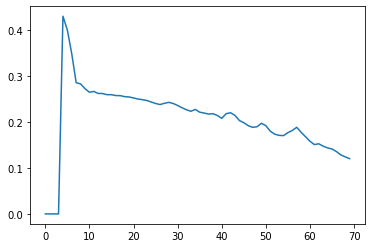

In [373]:
import time
# train face1
trainStep = getTrainStap(model)

EPOCHS = 70

import random
lossHistory = []
epochsRange = []
start = time.time()
for epoch in range(EPOCHS):
    trainLoss.reset_states()
    valiLoss.reset_states()
        
    for origin, dest in trainDataset:
        trainStep(origin, dest)
    # 验证集
    for origin, dest in valiDataset:
        valiPredictions = model.encode(origin)
        valiPredictions = model.decode(valiPredictions)
        valiLoss(loss_object(dest, valiPredictions))

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {trainLoss.result()}, '
        f'Validation Loss: {valiLoss.result()}, '
        f'\n {int((time.time() - start) / (epoch + 1) * (EPOCHS - epoch)) / 60} minutes left, '
    )
    if trainLoss.result() < 0.5:
        lossHistory.append(trainLoss.result())
    else:
        lossHistory.append(0)
    epochsRange.append(epoch)

plt.plot(epochsRange,lossHistory)

(2, 64, 64, 1)


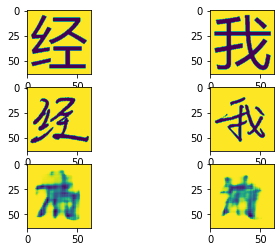

In [374]:
showDatasetPerdiction(valiDataset, model)

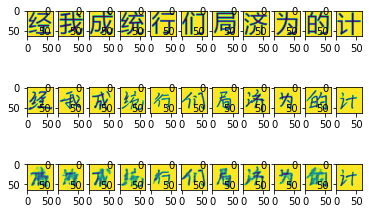

In [375]:
fig, ax = plt.subplots(ncols=len(originFiles),nrows=3)

col = 0
for origin, dest in dataset:
  prediction = model(origin)

  for i in range(len(origin)):
    ax[0][col].imshow(origin[i].numpy().reshape(IMGSIZE))
    ax[1][col].imshow(dest[i].numpy().reshape(IMGSIZE))
    ax[2][col].imshow(prediction[i].numpy().reshape(IMGSIZE))
    col += 1 

(1, 64, 64, 1)


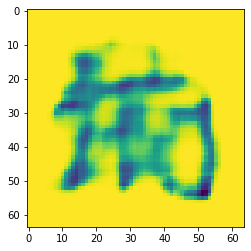

In [376]:
img = PIL.Image.open('./new.jpg')
# 如果第三个维度是 rgb，则转换为二值化图像
if len(img.split()) == 3:
  img = img.convert('L')
img = img.resize(IMGSIZE)
img = np.array(img) / 255
img = img.reshape((1, *IMGSIZE, 1))
perdiction = model(img)
print(perdiction.shape)
plt.imshow(perdiction[0])